In [1]:
import mne
import numpy as np
from mne.preprocessing import ICA
from mne.time_frequency import (tfr_multitaper)

In [2]:
data_path = '/Users/44737483/Documents/alien_data/RS_pilot/2630_RS_PI160_2017_08_04_B1.con'
mrk = '/Users/44737483/Documents/alien_data/RS_pilot/2630_RS_PI160_2017_08_04_ini.mrk'
hsp = '/Users/44737483/Documents/alien_data/RS_pilot/2630_RS_PI160_2017_08_04.hsp'
elp = '/Users/44737483/Documents/alien_data/RS_pilot/2630_RS_PI160_2017_08_04.elp'

## Load Raw
raw = mne.io.read_raw_kit(data_path, mrk=mrk, elp=elp, hsp=hsp,
                          stim=['177','178'],slope='+',stim_code='channel',
                               preload=True)

Extracting SQD Parameters from /Users/44737483/Documents/alien_data/RS_pilot/2630_RS_PI160_2017_08_04_B1.con...
Creating Raw.info structure...
Setting channel info structure...
Creating Info structure...
Current compensation grade : 0
Reading 0 ... 845999  =      0.000 ...   845.999 secs...
Ready.


In [3]:
# Check layout is working
layout = mne.find_layout(raw.info,ch_type='meg')

Setting up band-stop filter
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
Filter length of 13200 samples (13.200 sec) selected


<ipython-input-4-863568a65f52>:5: DeprecationWarning: fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
  raw.notch_filter(np.arange(50, 251, 50), picks=picks)


Setting up band-pass filter from 0.1 - 1.5e+02 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 0.1 Hz
h_trans_bandwidth chosen to be 37.5 Hz
Filter length of 66000 samples (66.000 sec) selected


<ipython-input-4-863568a65f52>:8: DeprecationWarning: fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
  raw.filter(0.1,150,picks=picks)


128 events found
Events id: [177 178]
128 events found
Events id: [177 178]
Effective window size : 1.005 (s)


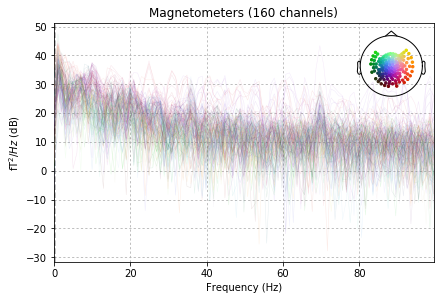

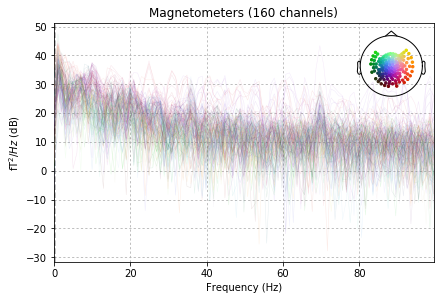

In [4]:
# Notch Filter (remove 50Hz line noise and harmonics)
picks = mne.pick_types(raw.info, meg='mag',eeg=False, eog=False,
                       stim=False, exclude='bads')

raw.notch_filter(np.arange(50, 251, 50), picks=picks)

# BP Filter between 0.1-150Hz
raw.filter(0.1,150,picks=picks)

# Resample to 200Hz to speed up computation
raw.resample(200, npad="auto")  # set sampling frequency to 200Hz

# Plot the PSD
raw.plot_psd(area_mode='range', tmax=1.0, average=False)

Fitting ICA to data using 160 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.
    Rejecting  epoch based on MAG : ['MEG 105']
Artifact detected in [21306, 21440]
    Rejecting  epoch based on MAG : ['MEG 102', 'MEG 105']
Artifact detected in [21842, 21976]
    Rejecting  epoch based on MAG : ['MEG 102', 'MEG 105']
Artifact detected in [36314, 36448]
Selection by number: 20 components


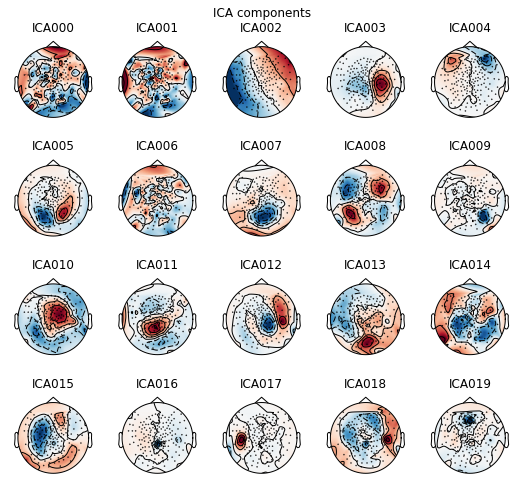

In [6]:
## ICA
method = 'fastica'

# Choose other parameters
n_components = 20  # if float, select n_components by explained variance of PCA
decim = 3  # we need sufficient statistics, not all time points -> saves time

# we will also set state of the random number generator - ICA is a
# non-deterministic algorithm, but we want to have the same decomposition
# and the same order of components each time this tutorial is run
random_state = 23

ica = ICA(n_components=n_components, method=method, random_state=random_state)
reject = dict(mag=5e-12, grad=4000e-13)

ica.fit(raw, picks=picks, decim=decim, reject=reject)

ica.plot_components()

In [7]:
## Epoch
events = mne.find_events(raw,stim_channel='STI 014')
print('Number of events:', len(events))
print('Unique event codes:', np.unique(events[:, 2]))
event_id = {'Grating': 177, 'Clicktrain': 178}

epochs = mne.Epochs(raw, events, event_id, tmin=-2, tmax=2,
                    baseline=(None, 0), preload=True)

128 events found
Events id: [177 178]
('Number of events:', 128)
('Unique event codes:', array([177, 178]))
128 matching events found
0 projection items activated
Loading data for 128 events and 801 original time points ...
0 bad epochs dropped


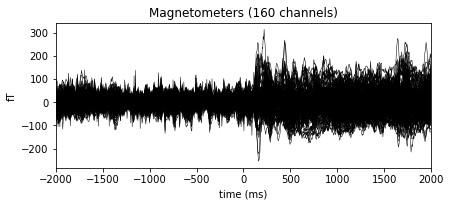

axis_facecolor is deprecated and will be removed in v0.16. Use background_color parameter or change matplotlib defaults.
axis_facecolor is deprecated and will be removed in v0.16. Use background_color parameter or change matplotlib defaults.
font_color is deprecated and will be removed in v0.16. Use background_color parameter or change matplotlib defaults.


<ipython-input-8-7a5bf52742ca>:7: RuntimeWarning: axis_facecolor is deprecated and will be removed in v0.16. Use background_color parameter or change matplotlib defaults.
  grating.average().plot_topo()
<ipython-input-8-7a5bf52742ca>:7: RuntimeWarning: axis_facecolor is deprecated and will be removed in v0.16. Use background_color parameter or change matplotlib defaults.
  grating.average().plot_topo()
<ipython-input-8-7a5bf52742ca>:7: RuntimeWarning: font_color is deprecated and will be removed in v0.16. Use background_color parameter or change matplotlib defaults.
  grating.average().plot_topo()


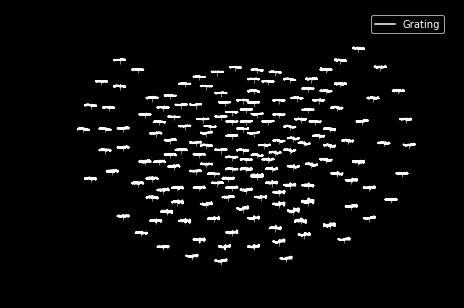

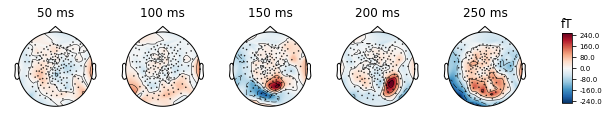

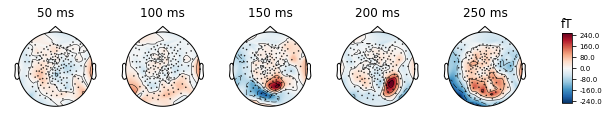

In [8]:
## Select Epochs and Average
grating = epochs['Grating']
clicktrain = epochs['Clicktrain']

# Average the grating trials and plot
grating.average().plot()
grating.average().plot_topo()

# Plot how the ERF changes from 0.05-0.3s
times = np.arange(0.05, 0.3, 0.05)
grating.average().plot_topomap(times=times, ch_type='mag')

In [9]:
## TFR
# Define frequencies 1-100 in 2Hz steps
freqs = np.arange(1.0, 100.0, 2.0)

n_cycles = freqs / 2.
time_bandwidth = 8.0  # Use multiple tapers (this will take a while)
power = tfr_multitaper(grating, freqs=freqs, n_cycles=n_cycles,picks=picks,
                       time_bandwidth=time_bandwidth, return_itc=False)

Applying baseline correction (mode: logratio)


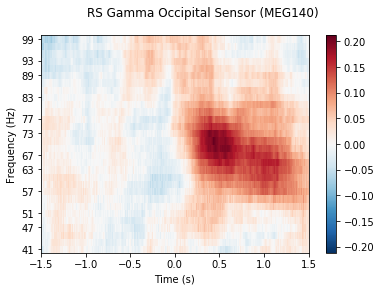

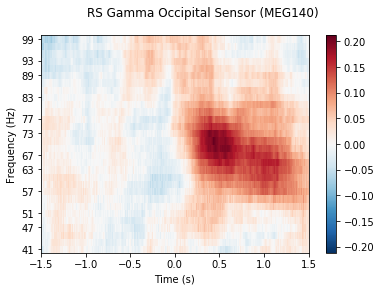

In [10]:
## Plot visual gamma :)

# Pick an occipital sensor for show
picks_occ = mne.pick_types(raw.info, meg='mag',eeg=False, eog=False,
                       stim=False, exclude='bads',selection=['MEG 140'])

power.plot(picks=picks_occ, baseline=(-1.5, 0.),fmin=40,tmin=-1.5,
           tmax=1.5, mode='logratio',title='RS Gamma Occipital Sensor (MEG140)')

Applying baseline correction (mode: logratio)


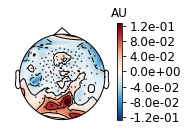

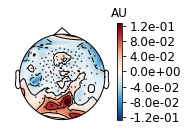

In [11]:
# Show visual gamma (40-70Hz) from 0.3-1.5s
power.plot_topomap(baseline=(-1.5, 0), fmin=40,fmax=70,tmin=0.3,
                   tmax=1.5,mode='logratio')

Applying baseline correction (mode: logratio)


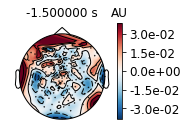

Applying baseline correction (mode: logratio)


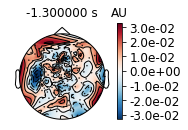

Applying baseline correction (mode: logratio)


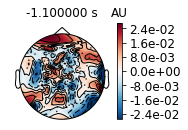

Applying baseline correction (mode: logratio)


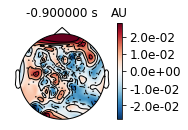

Applying baseline correction (mode: logratio)


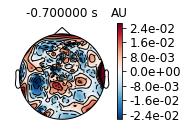

Applying baseline correction (mode: logratio)


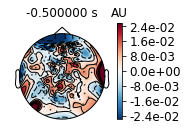

Applying baseline correction (mode: logratio)


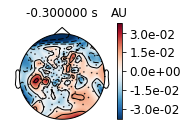

Applying baseline correction (mode: logratio)


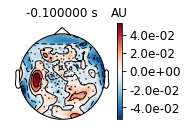

Applying baseline correction (mode: logratio)


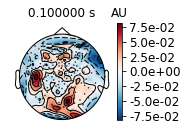

Applying baseline correction (mode: logratio)


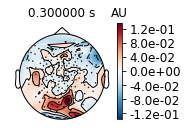

Applying baseline correction (mode: logratio)


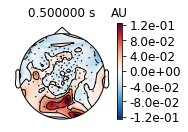

Applying baseline correction (mode: logratio)


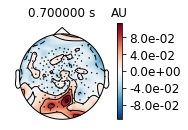

Applying baseline correction (mode: logratio)


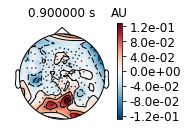

Applying baseline correction (mode: logratio)


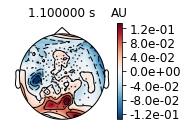

Applying baseline correction (mode: logratio)


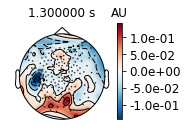

Applying baseline correction (mode: logratio)


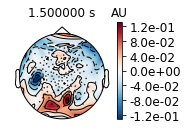

In [21]:
# Show how visual gamma changes over time from -1.5 to 1.5s
times = np.arange(-1.5, 1.7, 0.2)

for t in times:
    power.plot_topomap(baseline=(-1.5, 0), fmin=40,fmax=70,tmin=t-0.1,tmax=t+0.1, 
                   ch_type='mag',mode='logratio',title=('%f s'%(t)))